
### T1 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2024  

In [1]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\sk88\Documents\python_scripts")

import Function_files.data_functions as dat
from Function_files.fitting_functions import find_trigger, fit_exp_decay
from Function_files.math_functions import average_arrays
from Function_files.plotting_class import Spectra_Plotter
plt = Spectra_Plotter()

from scipy.integrate import simpson

from Lifetime.T1.configs import PrYVO as config_file

import os


##### Import Data  
        
        Load data sets & extract time and voltage data


In [2]:
# path to folders containing T1 data
path = os.path.join(config_file.root, config_file.file)
# extensions to look for in the folders
exts = config_file.extensions
# indexes for data
di = config_file.data_indexes
ti = config_file.trim_indexes
# make labels from data indexes
labels = [key for key in di.keys() if key != 'time']
# guesses for the T1 times
guess_ref_T1 = config_file.guess_ref_T1
guess_T1 = config_file.guess_T1
# populate folder and file lists
folder_list, file_list = dat.dir_interrogate(path, extensions=exts)
# create dictionary for indexing folders and files
folder_index = dat.make_index_dict(folder_list)
file_index = [dat.make_index_dict(file_sub_list) for file_sub_list in file_list]
# lists of the data paths and metadata (text) paths
data_path_list = dat.search_paths(folder_list, file_list, [exts[0]])
metadata_path_list = dat.search_paths(folder_list, file_list, [exts[1]])
# extract the relevant data from the files
excel_sets = [[dat.open_csv(os.path.join(path, data_path)) for data_path in data_paths] for data_paths in data_path_list]
if '.txt' in config_file.extensions:
        metadata = [dat.open_text(os.path.join(path, data_path)) for data_paths in metadata_path_list for data_path in data_paths]
        fluor_duration = [[float(dat.find_numbers(row)[0]) for row in text_file if dat.check_str(["durationFluor"], row.split())] for text_file in metadata]
elif '.json' in config_file.extensions:
        metadata = [dat.read_json(os.path.join(path, data_path)) for data_paths in metadata_path_list for data_path in data_paths]
        fluor_duration = [[data['pi_half_params']['duration'] for data in meta_files] for meta_files in metadata]


##### Fine Tune Trigger Point

        Check the trigger index and adjust if neccesary
        

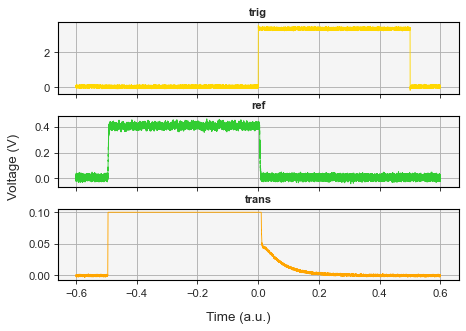

In [3]:
# plot channel data to check assignment (times are in us)
plt.scale_x = 1E4
fig, ax = plt.plot_scope(excel_sets[0][0][:,di['time']], [excel_sets[0][0][:,di['trig']], excel_sets[0][0][:,di['ref']], excel_sets[0][0][:,di['trans']]], titles=labels, multi=True)

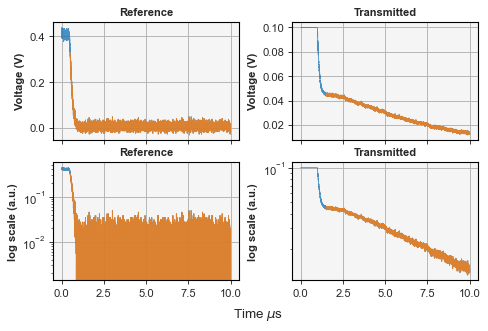

In [4]:
# find index of the trigger
trig_indexes = [[find_trigger(trig_data[:,di['trig']], modifier=.9) for trig_data in excel_data] for excel_data in excel_sets]
ti['trig'] = trig_indexes[0][0]
# calculate the time step
dt = (excel_sets[0][0][:,di['time']][1] - excel_sets[0][0][:,di['time']][0])*1E6
# create offset beased on time step
ti['ramp'] = round(10/dt) + trig_indexes[0][0]
ti['off'] = round(1.5/dt)
ti['ref_off'] = round(0.5/dt)

# plot transmitted and reference data to check the trigger index
plt.scale_x = 1E6
fig, ax = plt.plot_T1_trigger(excel_sets[0][0][:,di['time']], [excel_sets[0][0][:,di['ref']], excel_sets[0][0][:,di['trans']]], ti)


##### Process Data  

        Trim the data sets and find initial starting parameters for fitting
        Fit to the data and take average fit values


In [5]:
# # find start and stop indexes for the data (saves trying to fit to unnecesary data)
ref_stop_set = [[round(guess_ref_T1*4/(time[:,di['time']][1] - time[:,di['time']][0])) for time in time_lists] for time_lists in excel_sets]
stop_set = [[round(guess_T1*8 /(time[:,di['time']][1] - time[:,di['time']][0])) for time in time_lists] for time_lists in excel_sets]
start_set = [[value + ti['off'] for value in trig_index] for trig_index in trig_indexes]
ref_start_set = [[value + ti['ref_off'] for value in trig_index] for trig_index in trig_indexes]
# create new arrays of cut data using start and stop indexes found
time_sets = [[data[:,di['time']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, start_set, stop_set)]
ref_time_sets = [[data[:,di['time']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, ref_start_set, ref_stop_set)]
trig_sets = [[data[:,di['trig']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, start_set, stop_set)]
trans_sets = [[data[:,di['trans']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, start_set, stop_set)]
ref_sets = [[data[:,di['ref']][start:start+stop] for data, start, stop in zip(data_list, start_list, stop_lists)] for data_list, start_list, stop_lists in zip(excel_sets, ref_start_set, ref_stop_set)]
# found initial start params for the fitting functions (minimum and maximum)
list_of_mins = [[min(trans) for trans in trans_lists] for trans_lists in trans_sets]
list_of_maxs = [[max(trans) for trans in trans_lists] for trans_lists in trans_sets]
ref_min_list = [[min(refs) for refs in ref_lists] for ref_lists in ref_sets]
ref_max_list = [[max(refs) for refs in ref_lists] for ref_lists in ref_sets]
# zip the fit data for the reference signal
ref_zip = zip(ref_time_sets, ref_sets, ref_max_list, ref_min_list)
data_zip = zip(time_sets, trans_sets, list_of_maxs, list_of_mins)
# fit to the reference data and average the fit
ref_fit_sets = [[fit_exp_decay(time, ref, params=(max_value, guess_ref_T1, min_value)) for time, ref, max_value, min_value in zip(time_set, ref_set, max_set, min_set)] for time_set, ref_set, max_set, min_set in ref_zip]
ref_fit_avg = [average_arrays(ref_list) for ref_list in ref_fit_sets]
# fit to the transmitted data and average the fit
data_fit_sets = [[fit_exp_decay(time, trans, params=(max_value, guess_T1, min_value)) for time, trans, max_value, min_value in zip(time_set, trans_set, max_set, min_set)] for time_set, trans_set, max_set, min_set in data_zip]
data_fit_avg = [average_arrays(data_list) for data_list in data_fit_sets]
# calculate area of the fluorescence
data_area_sets = [[simpson(y=trans, x=time) for trans, time in zip(trans_set, time_set)] for trans_set, time_set in zip(trans_sets, time_sets)]
data_area_avg = [average_arrays(data_list) for data_list in data_area_sets]

(<Figure size 480x320 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Fit'}, xlabel='Time $\\mu$s', ylabel='Voltage V'>,
        <Axes: title={'center': 'Log Scale Fit'}, xlabel='Time $\\mu$s', ylabel='Voltage V'>],
       dtype=object))

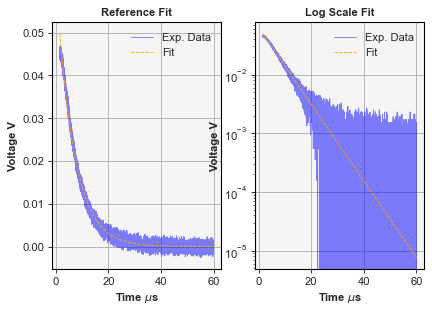

In [7]:
plt.plot_T1_fit(time_sets[0][0], trans_sets[0][0], data_fit_sets[0][0])

In [80]:
keys = ['I0', 'T1', 'y0']
err_keys = ['dI0', 'dT1', 'dy0']
fit_data = {}

for duration, data_fit, data_area in zip(fluor_duration, data_fit_avg, data_area_avg):
    duration_dict = {}
    for key, value in zip(keys, data_fit[0][0].flatten().tolist()):
        duration_dict[key] = value
    for key, value in zip(err_keys, data_fit[1][0].flatten().tolist()):
        duration_dict[key] = value
    # Add area to the dict
    duration_dict['A'] = data_area[0]
    duration_dict['dA'] = data_area[1]
    # After populating duration_dict with all key-value pairs, assign it to fit_data
    fit_data[duration[0]] = duration_dict

In [ ]:
# save the data to file
dat.write_json(config['file'] + '_fit.json', fit_data)